In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

Text(0.5, 1.0, 'Wind-PEM Marginal Cost Curve at T=t')

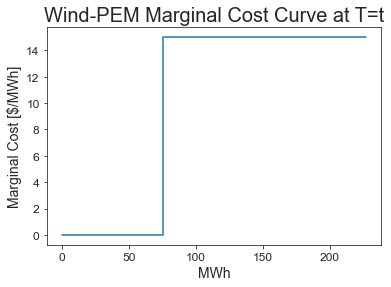

In [2]:
mws = np.linspace(0, 227.05, 10)
m_cost = [0 if mw < (227.05 - 127.05) else 15 for mw in mws]
plt.step(mws, m_cost)
plt.xlabel("MWh")
plt.ylabel("Marginal Cost [$/MWh]")
plt.title("Wind-PEM Marginal Cost Curve at T=t")

In [3]:
import glob
import numpy as np
from dispatches.case_studies.renewables_case.double_loop_utils import read_rts_gmlc_wind_inputs
from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.load_parameters import wind_cap_cost, wind_op_cost, pem_cap_cost, pem_op_cost, pem_var_cost, PA

sweep_dir = Path("/Users/dguittet/Projects/Dispatches/NN_models/results_renewable_sweep_Wind_H2/results_parameter_sweep_15_1000")
wind_cf = read_rts_gmlc_wind_inputs(rts_gmlc.source_data_path, gen_name="303_WIND_1", agg_func="first")['303_WIND_1-RTCF']
params = pd.read_csv(sweep_dir / "sweep_parameters.csv")

records = []
for filename in glob.glob(str(sweep_dir / "*results*.csv")):
    res = pd.read_csv(filename)
    ind = int(Path(filename).stem.split('_')[-1])
    pem_bid = params['PEM_bid'][ind]
    pem_size = params['PEM_power_capacity'][ind]
    e_revenue = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values * 847 - res['Dispatch'], 0, pem_size)
    h2_price = 3
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    records.append({
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        "pem_bid": pem_bid,
        "pem_mw": pem_size,
        'NPV': npv})
sweep_results = pd.DataFrame(records)
sweep_results['pem_bid_round'] = sweep_results['pem_bid'].astype('int')
sweep_results['pem_mw_round'] = sweep_results['pem_mw'].astype('int')
sweep_results['e_revenue_mil'] = (sweep_results['e_revenue'] * 1e-6)
sweep_results['h_revenue_mil'] = (sweep_results['h_revenue'] * 1e-6)
sweep_results['NPV_bil'] = (sweep_results['NPV'] * 1e-9)


In [42]:
re_case_dir = Path.cwd()
results = pd.read_csv(re_case_dir / "surrogate_results_subscen_5-90-5.csv")
results = results.drop(columns=["Unnamed: 0", 'wind_mw'])
results['pem_bid_round'] = results['pem_bid'].astype('int')
results['pem_mw_round'] = results['pem_mw'].astype('int')
results['e_revenue_mil'] = (results['e_revenue'] * 1e-6)
results['h_revenue_mil'] = (results['h_revenue'] * 1e-6)
results['NPV_bil'] = (results['NPV'] * 1e-9)
results

,pem_mw,pem_bid,e_revenue,h_revenue,NPV,freq_scen_0,freq_scen_1,freq_scen_2,freq_scen_3,freq_scen_4,...,freq_scen_55,freq_scen_56,freq_scen_57,freq_scen_58,freq_scen_59,pem_bid_round,pem_mw_round,e_revenue_mil,h_revenue_mil,NPV_bil
0,127.050,15.0,-9.055358e+06,9.741785e+06,-1.736712e+09,0.001860,0.001860,0.001860,0.001860,0.001860,...,0.001860,0.001860,0.001860,0.001860,0.001860,15,127,-9.055358,9.741785,-1.736712
1,148.225,15.0,-7.981061e+06,1.096294e+07,-1.751980e+09,0.001872,0.001872,0.001872,0.001872,0.001872,...,0.001872,0.001872,0.001872,0.001872,0.001872,15,148,-7.981061,10.962944,-1.751980
2,169.400,15.0,-6.912576e+06,1.214566e+07,-1.767914e+09,0.001881,0.001881,0.001881,0.001881,0.001881,...,0.001881,0.001881,0.001881,0.001881,0.001881,15,169,-6.912576,12.145660,-1.767914
3,190.575,15.0,-5.852921e+06,1.327111e+07,-1.784842e+09,0.001887,0.001887,0.001887,0.001887,0.001887,...,0.001887,0.001887,0.001887,0.001887,0.001887,15,190,-5.852921,13.271108,-1.784842
4,211.750,15.0,-4.805190e+06,1.432775e+07,-1.802987e+09,0.001890,0.001890,0.001890,0.001890,0.001890,...,0.001890,0.001890,0.001890,0.001890,0.001890,15,211,-4.805190,14.327752,-1.802987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,338.800,45.0,3.589080e+06,1.871422e+07,-1.908765e+09,0.003015,0.003015,0.003015,0.003015,0.003015,...,0.003015,0.003015,0.003015,0.003015,0.003015,45,338,3.589080,18.714224,-1.908765
191,359.975,45.0,4.467297e+06,1.898116e+07,-1.941366e+09,0.003154,0.003154,0.003154,0.003154,0.003154,...,0.003154,0.003154,0.003154,0.003154,0.003154,45,359,4.467297,18.981161,-1.941366
192,381.150,45.0,5.310035e+06,1.917483e+07,-1.975612e+09,0.003278,0.003278,0.003278,0.003278,0.003278,...,0.003278,0.003278,0.003278,0.003278,0.003278,45,381,5.310035,19.174827,-1.975612
193,402.325,45.0,6.114971e+06,1.926633e+07,-2.011973e+09,0.003385,0.003385,0.003385,0.003385,0.003385,...,0.003385,0.003385,0.003385,0.003385,0.003385,45,402,6.114971,19.266325,-2.011973


In [43]:
elec_rev_min = min(results['e_revenue_mil'].min(), sweep_results['e_revenue_mil'].min())
elec_rev_max = max(results['e_revenue_mil'].max(), sweep_results['e_revenue_mil'].max())
h2_rev_min = min(results['h_revenue_mil'].min(), sweep_results['h_revenue_mil'].min())
h2_rev_max = max(results['h_revenue_mil'].max(), sweep_results['h_revenue_mil'].max())
npv_min = min(results['NPV_bil'].min(), sweep_results['NPV_bil'].min())
npv_max = max(results['NPV_bil'].max(), sweep_results['NPV_bil'].max())

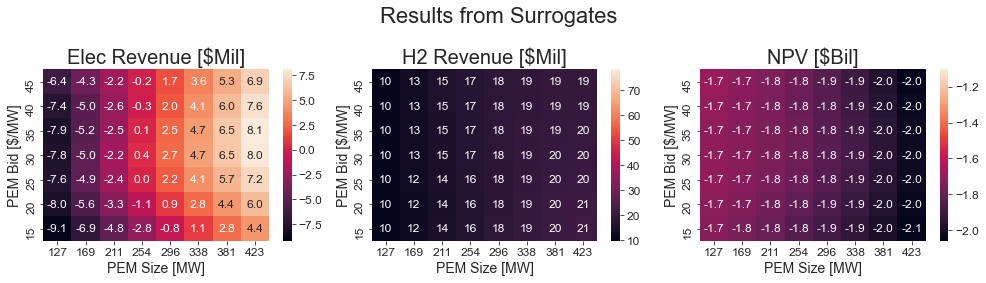

In [44]:
common_bids = set(results['pem_bid'].unique()).intersection(set(sweep_results['pem_bid'].unique()))
common_sizes = set(results['pem_mw'].round(2).unique()).intersection(set(sweep_results['pem_mw'].round(2).unique()))
results = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].round(2).isin(common_sizes))]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_bil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Bil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Results from Surrogates")
plt.tight_layout()

# Compare with Input Dataset from Prescient Sweep

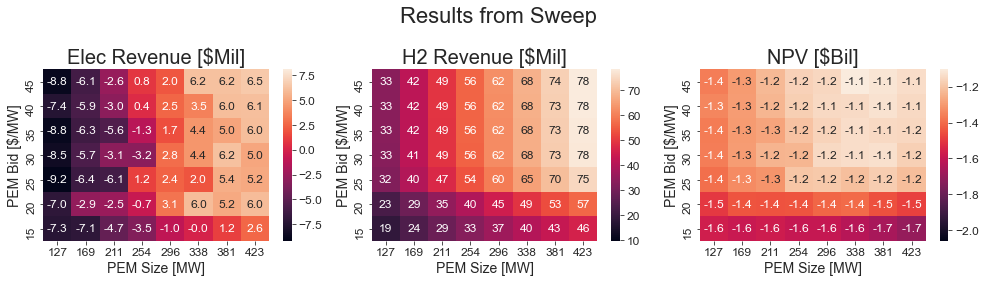

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_bil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Bil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Results from Sweep")
plt.tight_layout()

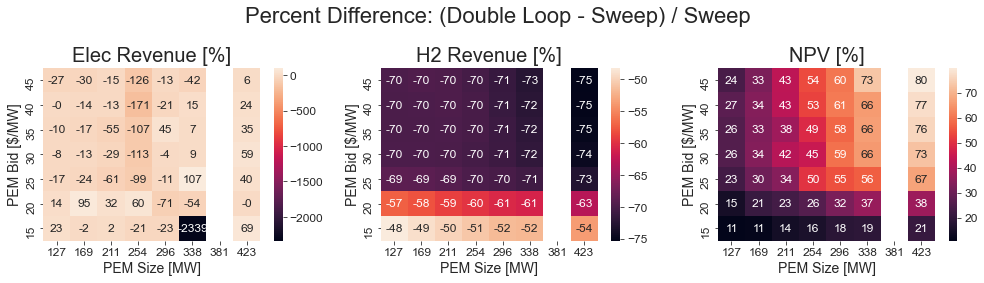

In [46]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff) / sweep_diff
    return diff_df * 1e2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue [%]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue [%]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_bil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV [%]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Percent Difference: (Double Loop - Sweep) / Sweep")
plt.tight_layout()

-3.2205881341231284 0.77762564725446
-59.11068551523532 -24.53024169506315
-0.9101911157274978 -0.35740496495162555


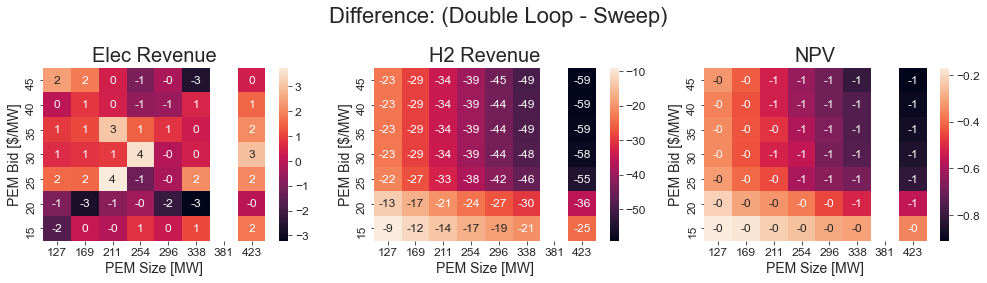

In [47]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff)
    print(min(diff_df.min()), min(diff_df.max()))
    return diff_df

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_bil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Difference: (Double Loop - Sweep)")
plt.tight_layout()

## Compare day frequencies

In [48]:
for day in range(20):
    results[f'percent_day_{day}'] = results[f'freq_day_{day}'] * 1e2
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
    sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=f'percent_day_{day}',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs)
    axs.set_title(f"Percent of Day {day}")
    axs.set_xlabel("PEM Size [MW]")
    axs.set_ylabel("PEM Bid [$/MW]")
    axs.invert_yaxis()

KeyError: 'freq_day_0'